In [26]:
%matplotlib ipympl 

import numpy as np
from matplotlib import pyplot as plt

from nugridpy import nugridse as nuse
from nugridpy import utils

import os
import sys
import contextlib
import pandas as pd

import h5py

from matplotlib import colors as mcolors
from matplotlib.ticker import MaxNLocator
from matplotlib.cm import ScalarMappable


from astropy import constants as const
from astropy import units as u

from IPython.display import display
import ipywidgets as widgets
import matplotlib.patches as patches

from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
import ipywidgets as widgets
import matplotlib.patches as patches

In [6]:
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout


In [22]:
def get_everything_you_need(mixing_case, sub_case="7.95E+03"):
    # the initial abundances for NOVA models are the Asplund et al. (2009) solar abundances 
    upper = "/data/niagara_project/projects/ocmerger_issa2025/RUNS/"
    if mixing_case != "GOSH": mppnp_test_dir=upper + f"{mixing_case}_RUNS/hif{sub_case}/H5_surf/"
    else: mppnp_test_dir=upper + f"{mixing_case}_RUNS/{sub_case}/H5_surf/"
    

    utils.solar("/data/niagara_project/projects/ocmerger_issa2025/CONDITIONS/iniab2.0E-02GN93.ppn",1.)
    sol_abu=utils.solar_elem_abund
    n_sol=len(sol_abu)
    n_el = n_sol + 2  # n_sol + the unstable Tc (Z=43) and Pm (Z=61)
    
    el_name=["  " for x in range(n_el)]
    
    z_el=np.linspace(0,0,n_el)
    
    el_name[0]='n'
    for i in range(n_el):
        z_el[i]=float(i)       
        if (i>0):
            el_name[i]=utils.get_el_from_z(i)
    
    work_dir = mppnp_test_dir

    model = 11000
    
    h5_file = work_dir + "my_test_hif.0010001.surf.h5"
    
    with h5py.File(h5_file, 'r') as file:
        dset = file["/cycle"+str(model).zfill(10)+"/SE_DATASET"]
        el_abu_0 = dset['elem_massf_decay'][0]
        iso_abu_0 = dset['iso_massf_decay'][0]

    
        n_iso = len(iso_abu_0)
        iso_z=np.linspace(0,0,n_iso)
        iso_a=np.linspace(0,0,n_iso)
        iso_name=["  " for x in range(n_iso)]

        iso_name[0] = 'n'
        iso_name[1] = 'H'
        
        dseta = file["A"]
        dsetz = file["Z"]
        iso_a[:] = dseta[:]
        iso_z[:] = dsetz[:]

    
    isomers = ['ALm', 'KRm', 'CDm', 'LUm', 'TAm']
    start = n_iso - len(isomers)
    for isomer in isomers: 
        i = isomers.index(isomer)
        iso_name[start+i] = isomer
    
    for i in range(2,n_iso-len(isomers)):
        iz = int(iso_z[i])
        iso_name[i] = utils.get_el_from_z(int(iso_z[i]))
        
    iso_full_name = []
    for i in range(n_iso):
        iso_full_name.append(iso_name[i]+"-"+str(int(iso_a[i])))
    
    return el_abu_0, el_name, iso_abu_0, iso_full_name

In [16]:
aesthetics = {"MLT": 
                  {"markers": ['^', 'D','s','o'],
                   "colours": ['midnightblue','blue','cornflowerblue','tab:blue'],
                   "case_label": "MLT",
                   "linestyle": "solid",
                   "folders": ["0.00E+00", "7.95E+01", "7.95E+02", "7.95E+03"],
                   "ilabs": ['No Merger', r'$4\times10^{-5}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-4}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-3}~\mathrm{M}_\odot \mathrm{s^{-1}}$']},
              
              "PPM":
                  {"markers": ['^', 'o','s','D'],
                   "colours": ['darkorange','chocolate','orange','tab:orange'],
                   "case_label": r"$D_{\mathrm{3D{-}insp.}}$",
                   "linestyle": "dashed",
                   "folders": ["0.00E+00", "7.95E+01", "7.95E+02", "7.95E+03"],
                   "ilabs": ['No Merger', r'$4\times10^{-5}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-4}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-3}~\mathrm{M}_\odot \mathrm{s^{-1}}$']},
              
              "PPM3":
                  {"markers": ['^', 'o','D','s'],
                   "colours": ['darkgreen','seagreen','lime','tab:green'],
                   "case_label": r"$3\times D_{\mathrm{3D{-}insp.}}$",
                   "linestyle": "dotted",
                   "folders": ["0.00E+00", "7.95E+01", "7.95E+02", "7.95E+03"],
                   "ilabs": ['No Merger', r'$4\times10^{-5}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-4}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-3}~\mathrm{M}_\odot \mathrm{s^{-1}}$']},

              "PPM10":
                  {"markers": ['s', 'o','D','^'],
                   "colours": ['darkred','firebrick','indianred','tab:red'],
                   "case_label": r"$10\times D_{\mathrm{3D{-}insp.}}$",
                   "linestyle": "solid",
                   "folders": ["0.00E+00", "7.95E+01", "7.95E+02", "7.95E+03"],
                   "ilabs": ['No Merger', r'$4\times10^{-5}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-4}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-3}~\mathrm{M}_\odot \mathrm{s^{-1}}$']},
             
              "PPM50":
                  {"markers": ['s', 'o','D','v'],
                   "colours": ['rebeccapurple','mediumorchid','plum','tab:purple'],
                   "case_label": r"$50\times D_{\mathrm{3D{-}insp.}}$",
                   "linestyle": "dashed",
                   "folders": ["0.00E+00", "7.95E+01", "7.95E+02", "7.95E+03"],
                   "ilabs": ['No Merger', r'$4\times10^{-5}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-4}~\mathrm{M}_\odot \mathrm{s^{-1}}$',r'$4\times10^{-3}~\mathrm{M}_\odot \mathrm{s^{-1}}$']},
              
              "GOSH":
                  {"markers": ['D', 's', '^', 'v'],
                   "colours": ['tab:pink','lime','tab:brown','mediumturquoise'],
                   "case_label": "Quenched",
                   "linestyle": "dotted",
                   "folders": ["gosh", "gosh_stronger", "partial_merger", "partial_merger_stronger"],
                   "ilabs": ["GOSH-like", "Stronger GOSH-like", "Partial Merger", "Stronger Partial Merger"]
                  }
              
             }

In [17]:
xs, ys = [], []
results = []

for case in ["PPM", "PPM3", "PPM10", "PPM50"]:
    
    aes = aesthetics[case]
    
    for cidx in range(4):
        
        ing = aes["folders"][cidx]

        with suppress_stdout():
            el_abu_0, el_name, iso_abu_0, iso_name = get_everything_you_need(case, ing)

        kidx = el_name.index("K")
        k40idx = iso_name.index("K-40")

        k = el_abu_0[kidx]
        k40 = iso_abu_0[k40idx]
        
        result = np.log10(k40/k)
        
        yp = str(1) if case == "PPM" else case[3:]
        
        xp = aes["ilabs"][cidx]
        
        xs.append(xp)
        ys.append(yp)
        results.append(result)

In [33]:
def scale_size(value, minval, maxval, min_size=1, max_size=50, centre=0):

    abs_cent_value = np.abs(value - centre)
    
    normalize = np.max([np.abs(maxval-centre), np.abs(minval-centre)])
    
    normalized_value = abs_cent_value / normalize
    
    return normalized_value * (max_size - min_size) + min_size

In [19]:
def get_color(value, minFij, maxFij, cmap=plt.cm.jet, get='color'):
    '''Sets the colour bar scale.
    '''

    
    def set_scale():
        norm = mcolors.Normalize(vmin=minFij, vmax=maxFij)

        return norm

    norm = set_scale()
    
    if get == 'color':
        normalized_values = norm(value)

        rgba_colors = cmap(normalized_values)
        if type(rgba_colors) != type(np.array): rgba_colors = np.array(rgba_colors)
        rgba_colors[value < minFij, 3] = 0  # turn off if under minFij

        return rgba_colors
    
    elif get == 'map':
        return norm, cmap


In [23]:
xs_full, ys_full = [], []

results_k41 = []
results_k40 = []
results_k39 = []

results_k40_k = []

i, j = 0, 0
for case in aesthetics.keys():
    
    aes = aesthetics[case]
    
    for cidx in range(4):
        
        ing = aes["folders"][cidx]

        with suppress_stdout():
            el_abu_0, el_name, iso_abu_0, iso_name = get_everything_you_need(case, ing)

        kidx = el_name.index("K")
        k41idx = iso_name.index("K-41")
        k40idx = iso_name.index("K-40")
        k39idx = iso_name.index("K-39")

        k = el_abu_0[kidx]
        k41 = iso_abu_0[k41idx]
        k40 = iso_abu_0[k40idx]
        k39 = iso_abu_0[k39idx]

        
        # these conversion factors are just the O-shell :: I am pretending that my results will be the same as the whole model (!)
        # probably want to use ```convert_X_to_full_maybe``` approach (!)
        
        ritter_k40_k = 0.013226304138637686
        
        ritter_k41 = 4.2463066937874936e-07
        ritter_k40 = 1.0656244755441975e-06
        ritter_k39 = 7.907831974753051e-05
        ritter_k = 8.056857489245346e-05
        

        
        yp = aes["case_label"]
        
        xp = aes["ilabs"][cidx]
        
        xs_full.append(i)
        ys_full.append(j)
        
        
        results_k40_k.append((k40/k))
        
        results_k41.append(k41/ritter_k41)
        results_k40.append(k40/ritter_k40)
        results_k39.append(k39/ritter_k39)

        
        i += 1
        
        if i == 4: 
            i = 0
            j += 1
        
results_k40_k = np.array(results_k40_k)
results_k41 = np.array(results_k41)
results_k40 = np.array(results_k40)
results_k39 = np.array(results_k39)

In [27]:
def round_to_nearest(arr, step):
    '''Rounds the maximum and minimum of an array to the closest "step". 

    Parameters
    ----------
    arr: list or np.array
        The data to get the rounded maximum and minimum.

    step: float
        The value to round to.

    Returns
    -------
    floored_min: float
        The minimum rounded to the floor of the step
        (ie. if step == 10 and min is 3 then it rounds to 0).

    ceiled_max: float
         The maximum rounded to the ceiling of the step 
         (ie. if step == 10 and max is 8 then it rounds to 10).
    '''

    min_val = np.min(arr)
    max_val = np.max(arr)

    floored_min = np.floor(min_val / step) * step
    ceiled_max = np.ceil(max_val / step) * step

    return floored_min, ceiled_max    

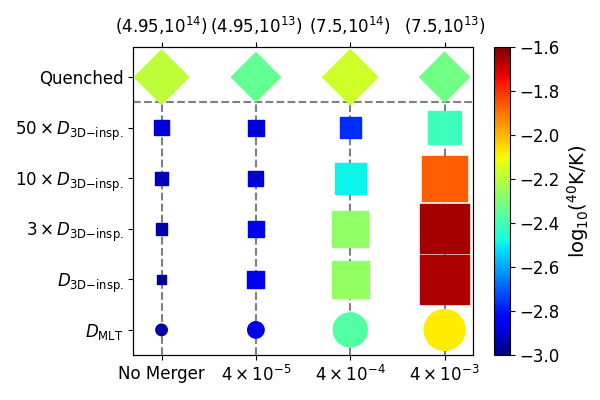

In [49]:
results = [results_k39, results_k40, results_k41, results_k40_k]
cbar_label = [r'$\log_{10}(^{39}\mathrm{K}_{\mathrm{Issa+25}} \div ^{39}\mathrm{K}_{\mathrm{Ritter+18}})$', \
              r'$\log_{10}(^{40}\mathrm{K}_{\mathrm{Issa+25}} \div ^{40}\mathrm{K}_{\mathrm{Ritter+18}})$', \
              r'$\log_{10}(^{41}\mathrm{K}_{\mathrm{Issa+25}} \div ^{41}\mathrm{K}_{\mathrm{Ritter+18}})$', \
              r'$\log_{10}({}^{40}\mathrm{K}/\mathrm{K})$']

result = results[3]
cbarlabel = cbar_label[3]

result = np.log10(result)

ifig=2;plt.close(ifig);
fig,ax=plt.subplots(num=ifig, figsize=(6,4))

min_scale, max_scale = round_to_nearest(result, 0.2)

ax.scatter(xs_full[:4], ys_full[:4], c=get_color(result[:4], min_scale, max_scale), \
                 s=scale_size(result[:4], min_scale, max_scale, min_size=20, max_size=1300, centre=min_scale), zorder=10)

ax.scatter(xs_full[4:20], ys_full[4:20], c=get_color(result[4:20], min_scale, max_scale), marker='s', \
                 s=scale_size(result[4:20], min_scale, max_scale, min_size=20, max_size=1300, centre=min_scale), zorder=10)

ax2 = plt.twiny()

ax2.scatter(xs_full[20:], ys_full[20:], c=get_color(result[20:], min_scale, max_scale), marker='D', \
                 s=scale_size(result[20:], min_scale, max_scale, min_size=20, max_size=1300, centre=min_scale), zorder=10)

ax2.axhline(4.5, color="grey", linestyle='--')

norm, cmap = get_color(0, min_scale, max_scale, get='map')
sm = ScalarMappable(norm=norm, cmap='jet')
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.tick_params(labelsize=12)  # Set tick label font size
cbar.set_label(cbarlabel, fontsize=14)  # Label font size

ax.set_xticks([0,1,2,3])
ax.set_xticklabels(labels=['No Merger', r'$4\times10^{-5}$',r'$4\times10^{-4}$',r'$4\times10^{-3}$'], fontsize=12)

ax.set_yticks([0,1,2,3,4,5])
ax.set_yticklabels(labels=[r'$D_{\mathrm{MLT}}$',r"$D_{\mathrm{3D{-}insp.}}$",r"$3\times D_{\mathrm{3D{-}insp.}}$",r"$10\times D_{\mathrm{3D{-}insp.}}$",r"$50\times D_{\mathrm{3D{-}insp.}}$", "Quenched"], fontsize=12)

for i in range(4):
    ax.axvline(i, ymin=0,ymax=4.23/5, color='grey', linestyle='--')


ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(labels=[r"(4.95,$10^{14}$)", r"(4.95,$10^{13}$)", r"(7.5,$10^{14}$)", r"(7.5,$10^{13}$)"], fontsize=12)


ax.set_xlim(-0.3,3.3)
ax2.set_xlim(-0.3,3.3)
ax2.set_ylim(-0.5,5.6)
plt.tight_layout()

plt.savefig("../figures/k40_k.pdf")